In [257]:
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

import requests
import io
from urllib.parse import urlencode

### Вариант 3
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.

* Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.


In [258]:
# Подготавливаем общие настройки для графиков

sns.set(
    rc={
        "figure.figsize": (12, 8), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 20, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
    }
)

sns.set_style("whitegrid") #тема фона, белая со штриховкой

### 1. Exploratory Data Analysis¶

Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка 


transactions_*.csv – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

Файлы:

- users_test – информация о пользователях в тестовой группе. 
- users_control_1 – информация о пользователях в первой контрольной группе. 
- users_control_2 – информация о пользователях во второй контрольной группе . 
- transactions_test – информация о платежах пользователей в тестовой группе. 
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

In [259]:
# загрузка файлов с ydisk
def read_csv_from_ydisk(folder_url):
    # Базовый URL для получения загрузочной ссылки для публичных ресурсов
    base_download_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    df = pd.DataFrame()
    try:
        # Формируем URL для получения прямой ссылки на скачивание
        # public_key - это ваша публичная ссылка на файл
        final_url = base_download_url + urlencode(dict(public_key=folder_url))

        # 1. Получаем прямую ссылку на скачивание файла
        response = requests.get(final_url)
        response.raise_for_status() # Проверяем на ошибки HTTP
        download_link = response.json()['href']

        # 2. Скачиваем файл по полученной прямой ссылке
        file_content_response = requests.get(download_link)
        file_content_response.raise_for_status() # Проверяем на ошибки

        # 3. Читаем CSV из содержимого файла, используя pandas
        csv_data = io.StringIO(file_content_response.text)
        df = pd.read_csv(csv_data, sep = ';')


    except requests.exceptions.RequestException as e:
        print(f"Ошибка при работе с API Яндекс.Диска или скачивании файла: {e}")
    except KeyError:
        print(f"Не удалось получить прямую ссылку для скачивания по публичной ссылке '{folder_url}'. Убедитесь, что файл доступен публично и ссылка корректна.")
    except Exception as e:
        print(f"Произошла непредвиденная ошибка: {e}")
    return df    
        

In [260]:
users_test_url = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'
users_control1_url = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
users_control2_url = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'

transactions_test_url = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
transactions_control1_url = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
transactions_control2_url = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

#Загружаем датасеты для анализа
users_test = read_csv_from_ydisk(users_test_url)
users_control1 = read_csv_from_ydisk(users_control1_url)
users_control2 = read_csv_from_ydisk(users_control2_url)

transactions_test = read_csv_from_ydisk(transactions_test_url)
transactions_control1 = read_csv_from_ydisk(transactions_control1_url)
transactions_control2 = read_csv_from_ydisk(transactions_control2_url)

In [261]:
users_test[users_test.uid == 892236423]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
406,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823


In [262]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [263]:
users_test.isna().sum()
#пропусков по обязательным полям нет, дополнительная фильтрация не нужна

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [264]:
print('Дубликатов uid:', users_test.duplicated(subset='uid').sum())
#все id пользователей уникальны, дополнительная фильтрация не нужна

Дубликатов uid: 0


In [265]:
users_control1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [266]:
users_control1.info()
#пропусков по обязательным полям нет, дополнительная фильтрация не нужна

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [267]:
print('Дубликатов uid:', users_control1.duplicated(subset='uid').sum())
#все id пользователей уникальны, дополнительная фильтрация не нужна

Дубликатов uid: 0


In [268]:
users_control2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [269]:
users_control2.info()
#пропусков по обязательным полям нет, дополнительная фильтрация не нужна

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [270]:
print('Дубликатов uid:', users_control2.duplicated(subset='uid').sum())
#все id пользователей уникальны, дополнительная фильтрация не нужна

Дубликатов uid: 0


In [271]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [272]:
transactions_test.info()
#пропусков по обязательным полям нет, дополнительная фильтрация не нужна

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [273]:
# Преобразуем нужные колонки к типу даты
transactions = [transactions_test, transactions_control1, transactions_control2]
for trans in transactions: 
    trans['joined_at'] = pd.to_datetime(trans['joined_at'])
    trans['paid_at'] = pd.to_datetime(trans['paid_at'])

In [274]:
print('Дубликатов транзакций', transactions_test.duplicated().sum())

Дубликатов транзакций 7


In [275]:
# 7 транзакций абсолютно одинаковые, почистим данные от них
transactions_test = transactions_test.drop_duplicates()

In [276]:
# проверим все ли мы убрали и преобразовали правильно
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           266 non-null    int64         
 1   country       266 non-null    object        
 2   joined_at     266 non-null    datetime64[ns]
 3   paid_at       266 non-null    datetime64[ns]
 4   revenue       266 non-null    int64         
 5   payment_id    266 non-null    int64         
 6   from_page     266 non-null    object        
 7   product_type  266 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 18.7+ KB


In [277]:
transactions_control1.info()
# есть много пропусков по обязательным полям, нужно их убрать, и преобразовать даты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


In [278]:
transactions_control1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [279]:
#Очищаем данные, удаляем строчки с пустыми uid
transactions_control1 = transactions_control1.dropna(subset=['uid'])

In [280]:
print('Дубликатов транзакций', transactions_control1.duplicated().sum())

Дубликатов транзакций 21


In [281]:
# 20 транзакций абсолютно одинаковые, почистим данные от них
transactions_control1 = transactions_control1.drop_duplicates()

In [282]:
transactions_test.product_type.value_counts()

coins               101
premium_no_trial     76
trial_premium        62
other_type           27
Name: product_type, dtype: int64

In [283]:
# проверим все ли мы убрали и преобразовали правильно
transactions_control1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           356 non-null    float64       
 1   country       356 non-null    object        
 2   joined_at     356 non-null    datetime64[ns]
 3   paid_at       356 non-null    datetime64[ns]
 4   revenue       356 non-null    float64       
 5   payment_id    356 non-null    float64       
 6   from_page     356 non-null    object        
 7   product_type  356 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 25.0+ KB


In [284]:
transactions_control1.product_type.value_counts()

coins               137
premium_no_trial    106
trial_premium        67
other_type           46
Name: product_type, dtype: int64

In [285]:
transactions_control2.info()
# пропусков по обязательным полям нет, нужно только преобразовать даты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


По условию в эксперимент должны попадать только новые пользователи, поэтому во всех группах дата, когда присоединился пользователь должна быть не раньше даты начала эксперимента

In [286]:
for trans in transactions:
    print(f"min date {trans['joined_at'].min()}, max date {trans['joined_at'].max()}")

min date 2017-01-11 03:07:00, max date 2017-10-31 23:40:00
min date 2015-01-19 11:49:00, max date 2017-10-31 22:17:00
min date 2017-01-11 08:36:00, max date 2017-10-31 17:43:00


Дата начала эксперимента: 2017-01-11

Дата окончания набора пользователей в эксперимент: 2017-10-31


In [287]:
# Убираем пользователей, которые пришли раньше даты начала эксперимента (2017-01-11)
# Создаем маску для ID, которые нужно удалить
mask = users_control1['uid'].isin(transactions_control1[transactions_control1.joined_at < '2017-01-11 00:00:00'].uid)
# Удаляем пользователей, которые не участвуют в эксперименте
users_control1 = users_control1[~mask]
transactions_control1 = transactions_control1[transactions_control1.joined_at >= '2017-01-11 00:00:00']

In [288]:
#Проверим, что дата регистрации меньше, чем даты транзакций
transactions_control1[transactions_control1.joined_at > transactions_control1.paid_at]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891721851.0,United States of America,2017-10-29 02:50:00,2017-05-11 07:15:00,4602.0,146.0,empty_likes,coins
14,892277877.0,United States of America,2017-10-17 03:36:00,2017-10-11 15:23:00,897.0,19.0,empty_likes,coins
20,892366260.0,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-09-11 20:06:00,6305.0,19.0,autorefill,coins
21,891707061.0,Argentina,2017-10-29 10:54:00,2017-04-11 00:30:00,1261.0,19.0,empty_likes,coins
23,891707061.0,Argentina,2017-10-29 10:54:00,2017-10-11 00:04:00,1261.0,19.0,autorefill,coins
24,892207959.0,France,2017-10-18 18:30:00,2017-01-11 04:39:00,1261.0,19.0,empty_likes,coins
32,891671796.0,Canada,2017-10-29 22:06:00,2017-06-11 00:06:00,9854.0,147.0,trial_vip_popup,trial_premium
51,891707061.0,Argentina,2017-10-29 10:54:00,2017-07-11 23:53:00,1261.0,19.0,menu,coins
54,891850512.0,Portugal,2017-10-26 10:34:00,2017-02-11 13:43:00,5577.0,147.0,trial_vip_popup,trial_premium
59,891693753.0,Turkey,2017-10-29 15:24:00,2017-04-11 20:45:00,5304.0,19.0,empty_likes,coins


In [289]:
#Оставляем только тех пользователей, у которых дата покупки больше, даты регистариции,
#т к сначала пользователи регистрируются, а потом только уже делают какие-то покупки в приложении
#С отправкой аналитики у этих пользователей что-то не так, поэтому исключим их из анализа
def filter_incorrect_joined_at(user, trans):
    # Создаем маску для ID, которые нужно удалить
    mask = user['uid'].isin(trans[trans.joined_at > trans.paid_at].uid)
    # Удаляем пользователей
    user = user[~mask]
    trans = trans[trans.joined_at <= trans.paid_at]

In [290]:
filter_incorrect_joined_at(users_control1, transactions_control1)
filter_incorrect_joined_at(users_control2, transactions_control2)
filter_incorrect_joined_at(users_test, transactions_test)


In [291]:
# посмотрим как много транзакций делали пользователи
transactions_test.uid.value_counts()

892236423    11
892065108     9
892057347     9
892339626     8
891861594     6
             ..
891904293     1
891907887     1
892354869     1
891867477     1
892071603     1
Name: uid, Length: 146, dtype: int64

In [292]:
transactions_test[transactions_test.uid == 892236423]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
17,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
81,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,31525,19,menu,coins
98,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,12610,19,menu,coins
112,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:09:00,12610,19,empty_likes,coins
125,892236423,United States of America,2017-10-18 01:09:00,2017-10-18 01:15:00,6292,147,left_sidebar_menu,premium_no_trial
139,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,3783,67,empty_likes,other_type
167,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,3783,67,menu,other_type
214,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,6305,19,empty_likes,coins


In [293]:
# сумма ревенью по всем транзакциям пользователя не совпадает с total_revenue из таблицы user_test
# почему???
transactions_test[transactions_test.uid == 892236423].revenue.sum()

86996

In [294]:
users_test[users_test.uid == 892236423]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
406,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823


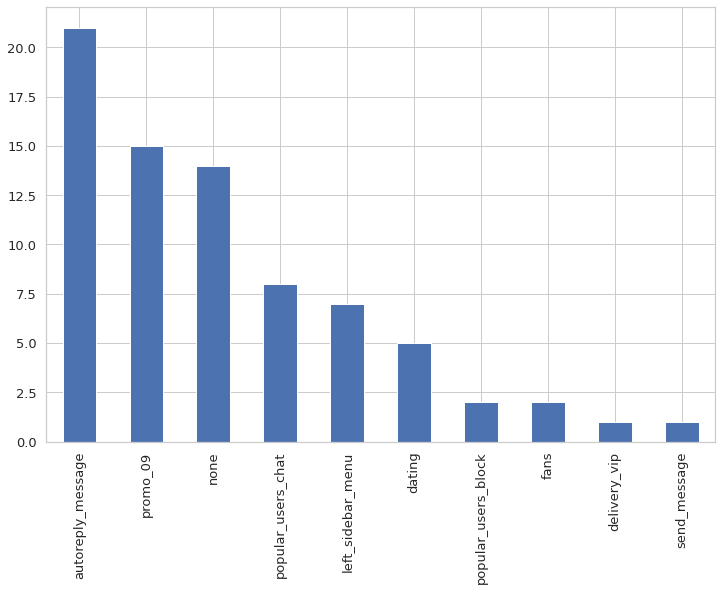

In [295]:
# посмотрим из каких мест можно купить премиальную подписку
transactions_test[transactions_test.product_type == 'premium_no_trial'].from_page.value_counts().plot(kind='bar')

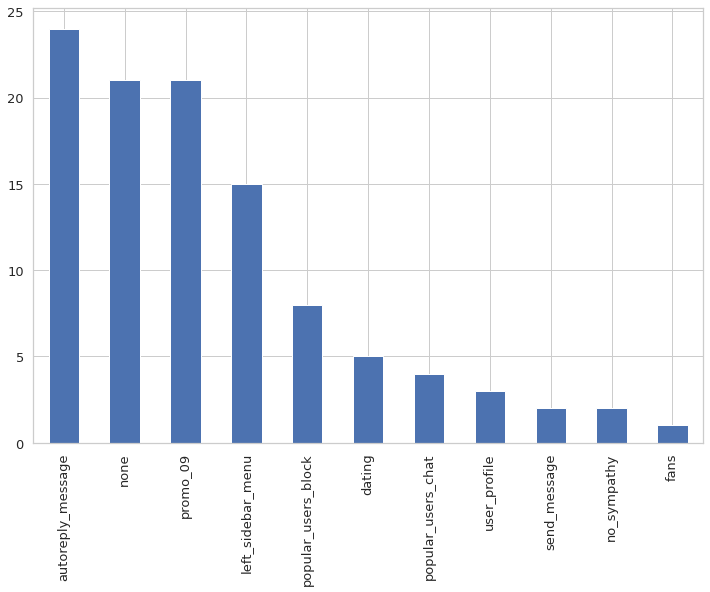

In [296]:
transactions_control1[transactions_control1.product_type == 'premium_no_trial'].from_page.value_counts().plot(kind='bar')

In [297]:
# теперь посмотрим на платежные системы, которые отвечают за премиум-подписку
transactions_test[transactions_test.product_type == 'premium_no_trial'].\
groupby(['payment_id']).agg({'product_type':'count'})

,product_type
payment_id,
0,1
68,12
147,63


In [298]:
transactions_control1[transactions_control1.product_type == 'premium_no_trial'].\
groupby(['payment_id']).agg({'product_type':'count'})

,product_type
payment_id,
0.0,2
68.0,16
147.0,88


In [299]:
transactions_control2[transactions_control2.product_type == 'premium_no_trial'].\
groupby(['payment_id']).agg({'product_type':'count'})

,product_type
payment_id,
0,1
68,14
147,92


Вывод: Скорее всего в эксперименте меняли цены для платежных систем с payment_id 68 и 147. Еще есть подозрительная платежная система с id 0. Возможно, это тестовая платежная система, через которую сделали пару покупок.

### 2. Проверка корректности работы системы сплитования

Проверим, сохраняется ли равномерное распределение трафика в различных сегментах пользователей. Это поможет выявить скрытые перекосы. Для анализа как раз нам подойдут две контрольные группы.

In [300]:
def chi2_check(cross):

    # Запускаем тест хи-квадрат на независимость
    chi2, p_value, dof, expected = stats.chi2_contingency(cross)

    # Интерпретируем результаты
    print(f"Статистика Хи-квадрат: {chi2:.4f}")
    print(f"P-значение (p-value): {p_value:.4f}")
    print(f"Степени свободы (dof): {dof}")
    print("\nОжидаемые частоты (если бы зависимости не было):")
    print(expected)

    # Уровень значимости
    alpha = 0.01

    if p_value < alpha:
        print("\nОтклоняем нулевую гипотезу: Распределение по группам ЗАВИСИТ от сегмента.")
        print("Вывод: Сплит работает по-разному для разных сегментов, что является проблемой.")
    else:
        print("\nНе удалось отклонить нулевую гипотезу: Распределение по группам НЕ зависит от сегмента.")
        print("Вывод: Сплит работает корректно в разрезе сегментов")


In [301]:
# Создаем таблицу сопряженности (contingency table)
cross = pd.concat([users_control1.country.value_counts().rename("users_control1"),users_control2.country.value_counts()], axis=1)

In [302]:
cross
# Некоторые страны не совпадают в двух группах. 
# Необходимо почистить данные и оставить пользователей только из старн, которые есть во всех группах

,users_control1,country
United States of America,1471.0,1486.0
Argentina,389.0,397.0
France,370.0,376.0
Spain,342.0,310.0
Italy,338.0,293.0
Chile,287.0,286.0
United Arab Emirates,207.0,211.0
Germany,188.0,202.0
United Kingdom (Great Britain),146.0,146.0
Canada,134.0,134.0


In [303]:
# убираем данные пользователей стран, которые не участвуют в эксперименте

In [304]:
cross = cross.dropna(subset=['country', 'users_control1'])

In [305]:

users_control1 = users_control1[users_control1.country.isin(cross.index)]
users_control2 = users_control2[users_control2.country.isin(cross.index)]
users_test = users_test[users_test.country.isin(cross.index)]

transactions_control1 = transactions_control1[transactions_control1.country.isin(cross.index)]
transactions_control2 = transactions_control2[transactions_control2.country.isin(cross.index)]
transactions_test = transactions_test[transactions_test.country.isin(cross.index)]

In [306]:
chi2_check(cross)

Статистика Хи-квадрат: 20.1013
P-значение (p-value): 0.7867
Степени свободы (dof): 26

Ожидаемые частоты (если бы зависимости не было):
[[1.49231776e+03 1.46468224e+03]
 [3.96672897e+02 3.89327103e+02]
 [3.76485981e+02 3.69514019e+02]
 [3.29046729e+02 3.22953271e+02]
 [3.18448598e+02 3.12551402e+02]
 [2.89177570e+02 2.83822430e+02]
 [2.10953271e+02 2.07046729e+02]
 [1.96822430e+02 1.93177570e+02]
 [1.47364486e+02 1.44635514e+02]
 [1.35252336e+02 1.32747664e+02]
 [9.43738318e+01 9.26261682e+01]
 [9.99252336e+01 9.80747664e+01]
 [1.00934579e+02 9.90654206e+01]
 [5.09719626e+01 5.00280374e+01]
 [3.88598131e+01 3.81401869e+01]
 [6.56074766e+00 6.43925234e+00]
 [1.31214953e+01 1.28785047e+01]
 [4.03738318e+00 3.96261682e+00]
 [6.56074766e+00 6.43925234e+00]
 [4.03738318e+00 3.96261682e+00]
 [1.51401869e+00 1.48598131e+00]
 [1.00934579e+00 9.90654206e-01]
 [1.00934579e+00 9.90654206e-01]
 [1.00934579e+00 9.90654206e-01]
 [1.00934579e+00 9.90654206e-01]
 [1.00934579e+00 9.90654206e-01]
 [1.51

In [307]:
cross = pd.concat([users_control1.gender.value_counts().rename("users_control1"),\
                   users_control2.gender.value_counts()], axis=1)

In [308]:
chi2_check(cross)

Статистика Хи-квадрат: 0.5860
P-значение (p-value): 0.4440
Степени свободы (dof): 1

Ожидаемые частоты (если бы зависимости не было):
[[4130.24299065 4053.75700935]
 [ 189.75700935  186.24299065]]

Не удалось отклонить нулевую гипотезу: Распределение по группам НЕ зависит от сегмента.
Вывод: Сплит работает корректно в разрезе сегментов


In [309]:
# Для непрырывной велечины Возраст будем использовать критерий однородности Колмогорова-Смирнова
ks_stat_same, p_value_same = stats.ks_2samp(users_control1.age, users_control2.age)

print(f"Статистика KS: {ks_stat_same:.4f}")
print(f"P-значение: {p_value_same:.4f}")

if p_value_same < 0.05:
    print("Отклоняем нулевую гипотезу: распределения, вероятно, различны.")
else:
    print("Не можем отклонить нулевую гипотезу: нет существенных доказательств различия распределений.")


Статистика KS: 0.0157
P-значение: 0.6611
Не можем отклонить нулевую гипотезу: нет существенных доказательств различия распределений.


Вывод: Сплит система работает корректно. Пользователи по сегментам страна, пол, возраст распределены равномерно по группам.

### 3. Формулируем гипотезу

Мы меняем цену только на премиум-подписку, но хотим узнать, как это повлияло на все приложения. Для этого за гланую метрику в тесте можно взять ARPU.   

Наша главная цель, скорее всего, — максимизировать доход. Изменение цены может увеличить или уменьшить количество покупок, и ARPU покажет чистый эффект на доход.

Н0: Если изменить(как?) стоимость премиум-подписки у новых пользователей через две новые платежные системы, то ARPU не изменится. 

H1: Если изменить(как?) стоимость премиум-подписки у новых пользователей через две новые платежные системы, то ARPU изменится с ??? до ???. 

### 4. Выбираем метрики для АБ теста

Выберем метрики для теста

Целевые метрики:
- ARPU даст глобальное понимание влияния изменения цены на подписку
- ARPPU покажет как изменился доход с наших платящих пользователей
- CR to Premium покажет привлекательней ли для пользователя стала покупка премиум-подписки


ARPU = ARPPU * CR to Premium

### 5. Анализируем результат

Мы уже проверили на двух контрольных группах, что сплит-система работает корректно. Поэтому контрольная группа 1 равнозначна контрольной группе 2. Можем объединить две контрольные группы для дальнейшего анализа.

In [310]:
# Для удобства объединяем данные теста в один датафрейм
users_test['group'] = 'test'
users_control1['group'] = 'control1'
users_control2['group'] = 'control1'

users_data = pd.concat([users_test, users_control1, users_control2])
transactions_data = pd.concat([transactions_test, transactions_control1, transactions_control2])

# Добавляем столбец с фактом совершения транзакции для подсчета конверсии
premium_users = transactions_data[transactions_data.product_type == 'premium_no_trial']['uid'].unique()
users_data['premium'] =  users_data.uid.isin(premium_users)


In [311]:
# Фиксируем уровень значимость и делаем поправку на множественное сравнение
alpha = 0.05 / 3

#### ARPU

In [312]:
print("\n--- Summary Statistics ---")
summary = users_data.groupby('group')['total_revenue'].agg(['count', 'sum', 'mean', 'median'])
summary.columns = ['total_users', 'total_revenue', 'ARPU', 'total_revenue_median']                   
print(summary)


--- Summary Statistics ---
          total_users  total_revenue        ARPU  total_revenue_median
group                                                                 
control1         8560        4476745  522.984229                     0
test             4271        2290717  536.342074                     0


In [313]:
print(f"ARPU lift: {np.round((summary.loc['test', 'ARPU']/summary.loc['control1', 'ARPU'] - 1)*100, 2)} %")

ARPU lift: 2.55 %


Выберем статистический критерий для ARPU. Будем считать, что выборки у нас независимы. Так ARPU мы считаем по пользователям и выборки мы разбивали по пользователям, то наблюдения у нас независимые. Осталось проверить как распределены наши данные, есть ли выбросы, проверить гомогенность дисперсий.

In [314]:
# Проверим равенство дисперсий(Тест Левена)
levene_stat, levene_p = stats.levene(users_test.total_revenue, users_control1.total_revenue)
print(f"Тест Левена: статистика={levene_stat:.3f}, p-значение={levene_p:.3f}")
if levene_p > 0.05:
    print("p-значение > 0.05: Нет достаточных оснований отвергнуть гипотезу о равенстве дисперсий.")
else:
    print("p-значение <= 0.05: Есть основания отвергнуть гипотезу о равенстве дисперсий.")


Тест Левена: статистика=0.192, p-значение=0.661
p-значение > 0.05: Нет достаточных оснований отвергнуть гипотезу о равенстве дисперсий.


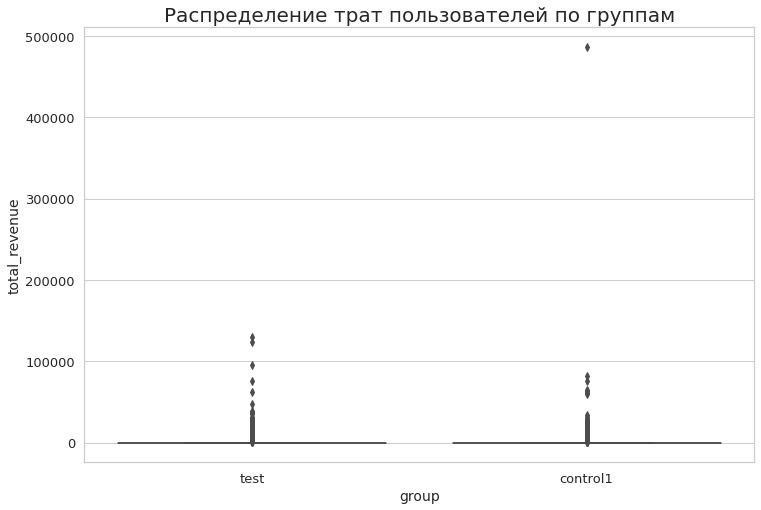

In [315]:
plt.title("Распределение трат пользователей по группам")
sns.boxplot(x="group", y="total_revenue", data=users_data, palette=["r", "g", "b"])

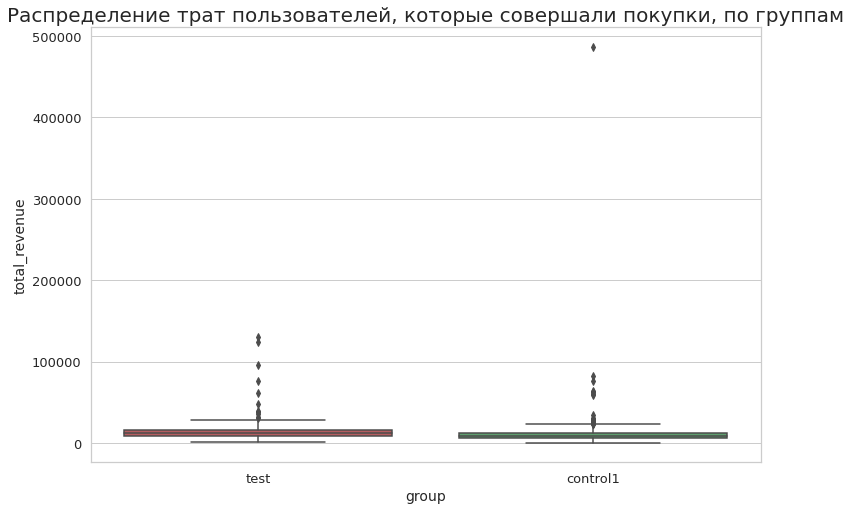

In [316]:
plt.title("Распределение трат пользователей, которые совершали покупки, по группам")
sns.boxplot(x="group", y="total_revenue", data=users_data[users_data.total_revenue > 0], palette=["r", "g", "b"])

Во всех выборках есть большие выбросы. Это пользователи, которые потратили намного больше других.
Если использовать t-test для выборок с большими выбросами, то мы повышаем вероятность ошибки второго рода, т е мы можем не найти различия там, где они есть. Попробуем применить тест на выборках с выбросами и без и сравнить результаты.


In [317]:
def ttest(a, b, equal_var):
    # Применение T-test
    statistic, pvalue = stats.ttest_ind(a, b, equal_var = equal_var)

    print(f"Статистика T-test: {statistic:.3f}")
    print(f"P-значение: {pvalue:.3f}")

    # Интерпретация результатов

    if pvalue > alpha:
        print(f"P-значение > {alpha}: Нет статистически значимых различий между средними нормированной выручки двух групп.")
    else:
        print(f"P-значение <= {alpha}: Есть статистически значимые различия между средними нормированной выручки двух групп.")


In [318]:
ttest(users_test.total_revenue, users_control1.total_revenue, equal_var = True)

Статистика T-test: -0.438
P-значение: 0.661
P-значение > 0.016666666666666666: Нет статистически значимых различий между средними нормированной выручки двух групп.


In [319]:
# Отфильтровываем данные, оставляя только те, что ниже или равны 99-му персентилю
users_test_filtered = users_test[users_test['total_revenue'] <= users_test['total_revenue'].quantile(0.99)]
users_control1_filtered = users_control1[users_control1['total_revenue'] <= users_control1['total_revenue'].quantile(0.99)]

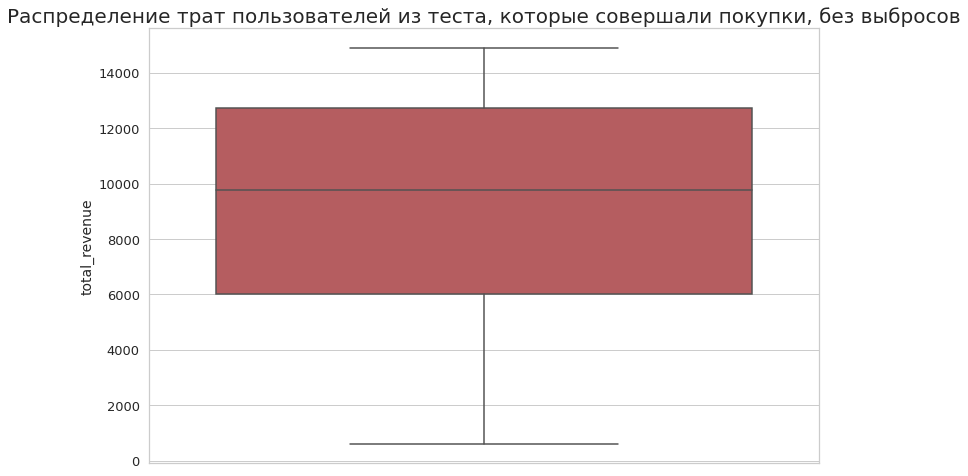

In [320]:
plt.title("Распределение трат пользователей из теста, которые совершали покупки, без выбросов")
sns.boxplot(y="total_revenue", data=users_test_filtered[users_test_filtered['total_revenue']>0], palette=["r", "g", "b"])

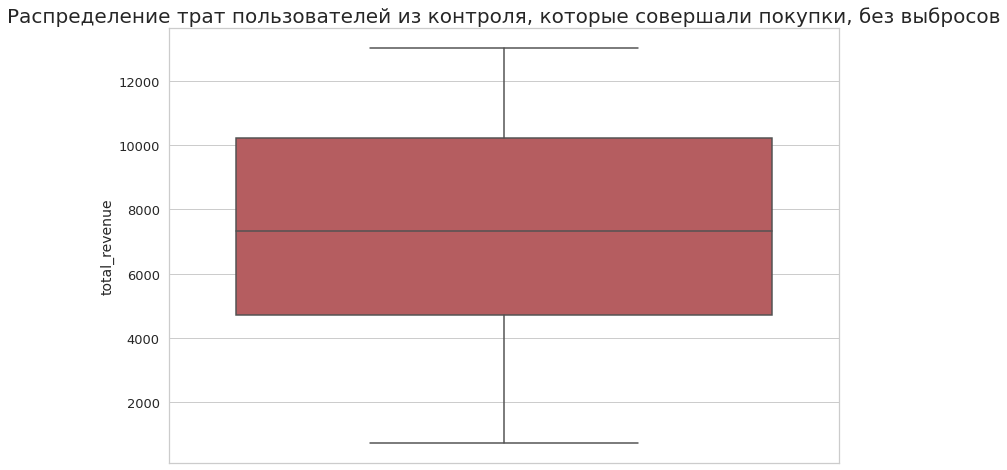

In [321]:
plt.title("Распределение трат пользователей из контроля, которые совершали покупки, без выбросов")
sns.boxplot(y="total_revenue", data=users_control1_filtered[users_control1_filtered['total_revenue']>0], palette=["r", "g", "b"])

In [322]:
ttest(users_test_filtered.total_revenue, users_control1_filtered.total_revenue, equal_var = True)

Статистика T-test: -1.220
P-значение: 0.223
P-значение > 0.016666666666666666: Нет статистически значимых различий между средними нормированной выручки двух групп.


 Вывод: Оба теста(с выбросами/без выбросов)показали, что ARPU стат знасимо не изменилось. Эксперимент не успешен.  

#### ARPPU

In [323]:
print("\n--- Summary Statistics ---")
summary = users_data[users_data.total_revenue != 0].groupby('group')['total_revenue'].agg(['count', 'sum', 'mean', 'median'])
summary.columns = ['total_users', 'total_revenue', 'ARPPU', 'total_revenue_median']                   
print(summary)


--- Summary Statistics ---
          total_users  total_revenue         ARPPU  total_revenue_median
group                                                                   
control1          376        4476745  11906.236702                  9087
test              145        2290717  15798.048276                 12727


In [324]:
print(f"ARPPU lift: {np.round((summary.loc['test', 'ARPPU']/summary.loc['control1', 'ARPPU'] - 1)*100, 2)} %")

ARPPU lift: 32.69 %


In [325]:
# Проверим равенство дисперсий(Тест Левена)
levene_stat, levene_p = stats.levene(users_test[users_test.total_revenue != 0].total_revenue, users_control1[users_control1.total_revenue != 0].total_revenue)
print(f"Тест Левена: статистика={levene_stat:.3f}, p-значение={levene_p:.3f}")
if levene_p > 0.05:
    print("p-значение > 0.05: Нет достаточных оснований отвергнуть гипотезу о равенстве дисперсий.")
else:
    print("p-значение <= 0.05: Есть основания отвергнуть гипотезу о равенстве дисперсий.")


Тест Левена: статистика=0.009, p-значение=0.925
p-значение > 0.05: Нет достаточных оснований отвергнуть гипотезу о равенстве дисперсий.


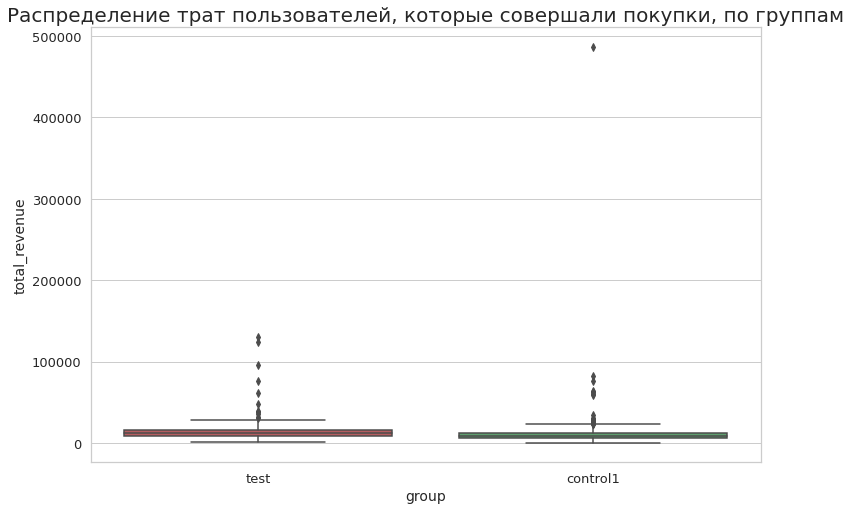

In [326]:
plt.title("Распределение трат пользователей, которые совершали покупки, по группам")
sns.boxplot(x="group", y="total_revenue", data=users_data[users_data.total_revenue != 0], palette=["r", "g", "b"])

Во всех выборках есть большие выбросы. Это пользователи, которые потратили намного больше других. Если использовать t-test для выборок с большими выбросами, то мы повышаем вероятность ошибки второго рода, т е мы можем не найти различия там, где они есть. Попробуем применить тест на выборках с выбросами и без и сравнить результаты.

In [327]:
ttest(users_test[users_test.total_revenue != 0].total_revenue, users_control1[users_control1.total_revenue != 0].total_revenue, equal_var = True)

Статистика T-test: 0.703
P-значение: 0.483
P-значение > 0.016666666666666666: Нет статистически значимых различий между средними нормированной выручки двух групп.


In [328]:
ttest(users_test_filtered[users_test_filtered.total_revenue != 0].total_revenue, users_control1_filtered[users_control1_filtered.total_revenue != 0].total_revenue, equal_var = True)

Статистика T-test: 3.188
P-значение: 0.002
P-значение <= 0.016666666666666666: Есть статистически значимые различия между средними нормированной выручки двух групп.


Вывод: Средний доход с платящего пользователя стат значимо изменился в положительную сторону после того, как убрали выбросы. Скорее всего из-за того, что цену на подписку подняли и те, кто покупают, соответственно стали платить нам больше, но это не покрыло наших потерь в конверсии в платящего пользователя. Не смотря на это эксперимент все равно не успешен, так как верхнеуровневая метрика ARPU стат значимо не изменилась.

#### Конверсия в премиум-подписку

In [329]:
print("\n--- Summary Statistics ---")
summary = users_data.groupby('group')['premium'].agg(['count', 'sum', 'mean'])
summary.columns = ['total_users', 'conversions', 'premium_conversion_rate']
print(summary)


--- Summary Statistics ---
          total_users  conversions  premium_conversion_rate
group                                                      
control1         8560          200                 0.023364
test             4271           66                 0.015453


In [330]:
print(f"premium_conversion_rate lift: {np.round((summary.loc['test', 'premium_conversion_rate']/summary.loc['control1', 'premium_conversion_rate'] - 1)*100, 2)} %")

premium_conversion_rate lift: -33.86 %


In [331]:
# Извлекаем данные для теста
count = np.array([summary.loc['test', 'conversions'], summary.loc['control1', 'conversions']])
nobs = np.array([summary.loc['test', 'total_users'], summary.loc['control1', 'total_users']])

# Проводим Z-тест
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided') # 'two-sided' для двусторонней гипотезы

print(f"\n--- Z-test for Proportions ---")
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-значение: {p_value:.4f}")


if p_value < alpha:
    print(f"P-значение ({p_value:.4f}) < alpha ({alpha}), отвергаем H0. Есть статистически значимая разница в конверсии.")
else:
    print(f"P-значение ({p_value:.4f}) >= alpha ({alpha}), не можем отвергнуть H0. Нет статистически значимой разницы в конверсии.")



--- Z-test for Proportions ---
Z-статистика: -2.9639
P-значение: 0.0030
P-значение (0.0030) < alpha (0.016666666666666666), отвергаем H0. Есть статистически значимая разница в конверсии.


Вывод: конверсия в покупку стат значимо упала. Отвергаем H0

### Анализ ежедневного ретеншена

Посмотрим повлияло ли изменение цены на retention всех пользователей и только премиум-пользователей

In [332]:

users_data['visit_days'] = users_data['visit_days'].fillna('0')
users_data['visit_days'] = users_data['visit_days'].str.split(',')

df = users_data[['uid', 'group', 'is_premium','visit_days']].explode('visit_days')
df['visit_days'] = df['visit_days'].astype(int)
df

,uid,group,is_premium,visit_days
0,892309896,test,NaN,1
0,892309896,test,NaN,2
0,892309896,test,NaN,3
0,892309896,test,NaN,4
0,892309896,test,NaN,5
...,...,...,...,...
4262,891697584,control1,NaN,10
4262,891697584,control1,NaN,12
4262,891697584,control1,NaN,14
4262,891697584,control1,NaN,15


In [333]:
ddf = df.groupby(['group', 'visit_days'], as_index = False)\
.agg({'uid':'count'})\
.sort_values(by = ['visit_days'])\
.pivot_table(index = ['visit_days'], values = 'uid', columns = 'group' )
ddf = ddf/ddf.loc[1]

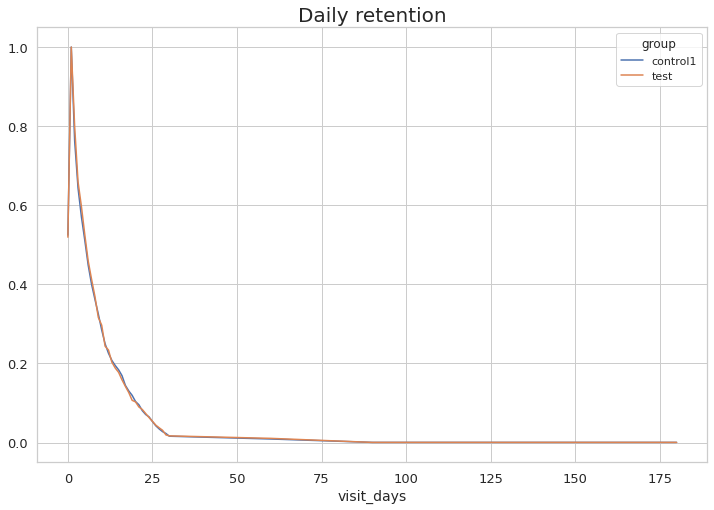

In [334]:
ddf.plot(title = 'Daily retention')

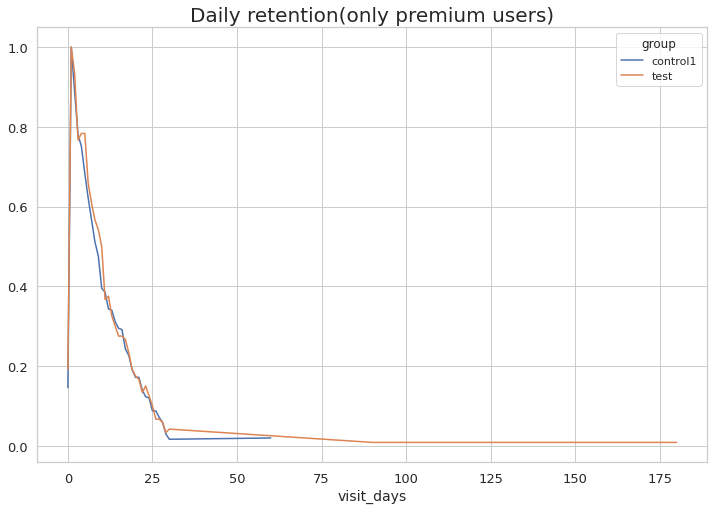

In [335]:
ddf = df[df.is_premium == True].groupby(['group', 'visit_days'], as_index = False)\
.agg({'uid':'count'})\
.sort_values(by = ['visit_days'])\
.pivot_table(index = ['visit_days'], values = 'uid', columns = 'group' )
ddf = ddf/ddf.loc[1]
ddf.plot(title = 'Daily retention(only premium users)')

Выводы: Судя по графикам, изменение цены не повлияло на возврощаемость премиум-пользователей и всех пользователей

### Анализ результатов в разрезе стран

Обычно у продукта разная цена в зависимости от страны. Люди из разных стран чаще всего по-разному реагируют на изменение цены. Поэтому посмотрим нашу главную метрику в разрезе стран и сравним группы.

In [336]:
def summary_ARPU(segment):
    summary = users_data.groupby(['group', segment])['total_revenue'].agg(['count', 'mean'])
    summary.columns = ['total_users','ARPU'] 
    summary = summary.reset_index().pivot_table(index=segment, columns='group', values=['total_users', 'ARPU'])
    summary['ARPU_lift %'] = np.round((summary[('ARPU', 'test')]/summary[('ARPU', 'control1')] - 1) * 100)
    print(summary)

In [337]:
summary_ARPU('country')

                                       ARPU              total_users          \
group                              control1         test    control1    test   
country                                                                        
Argentina                        338.049618   474.795455       786.0   396.0   
Australia                        405.445545   203.177419       101.0    62.0   
Belgium                          787.090909   681.369565       198.0    92.0   
Canada                           457.425373   463.255474       268.0   137.0   
Chile                            359.825480   257.132353       573.0   272.0   
China                              0.000000          NaN         2.0     NaN   
Colombia                           0.000000     0.000000         3.0     1.0   
Costa Rica                         0.000000     0.000000         2.0     1.0   
Dominican Republic                 0.000000     0.000000         3.0     1.0   
France                           446.949

Вывод: Из таблицы видим, что есть несколько стран (Germany, Spain, United Arab Emirates), в которых ARPU значительно выросло. Можно поднять цену только в этих странах и заново запустить эксперимент.

### Анализ результатов в разрезе пола

In [338]:
summary_ARPU('gender')

              ARPU             total_users       ARPU_lift %
group     control1        test    control1  test            
gender                                                      
0       229.436170  135.395000         376   200       -41.0
1       536.470797  556.039794        8184  4071         4.0


Выводы: Из таблицы видим, что ARPU просело для мужского и женского пола. В приложении очень мало женщин(на одну девушку 20 мужчин). Для дейтингового приложение перекосы по полу критичны. Нужно попробовать привлечь в приложение больше женщин и посмотреть, как это скажется на ключевые метрики.

### Анализ результатов в разрезе возраста

In [339]:
# Присвоение возрастных групп
users_data['age_group'] = pd.cut(users_data['age'], bins=5, right=True)

In [340]:
summary_ARPU('age_group')

                       ARPU              total_users       ARPU_lift %
group              control1         test    control1  test            
age_group                                                             
(15.917, 32.6]   586.890909   435.259634        5060  2569       -26.0
(32.6, 49.2]     435.401149   716.776398        2959  1449        65.0
(49.2, 65.8]     395.535156   365.755274         512   237        -8.0
(65.8, 82.4]       0.000000     0.000000          16     7         NaN
(82.4, 99.0]    1247.000000  5249.111111          13     9       321.0


Выводы: Из таблицы видим, что больше всего нашим приложением пользуются 2 возратные группы: 16-33 года и 33-49 лет.
ARPU для группы 16-33 упало на 26%, в то время как ARPU для группы 33-49 выросло на 65%. 
Можно предложить несколько идей экспериментов:
* Сделать два тарифа(подешевле, но меньше функций и подороже). Тогда мы возможно найдем компромисс для этих двух сегментов и ARPU пойдет вверх
* Сделать цену чуть ниже, чем сейчас в эксперименте. Возможно, этим мы уменьшим сильное падение ARPU у молодой аудитории.
* Сделать цену еще выше, чем в эксперименте. Возможно, рост ARPU у зрелой аудитории перекроет падение ARPU у молодой

### Выводы

Эксперимент с изменением цены на премиум-подписку признан не успешеным, так как наша главная метрика (ARPU) стат значимо не изменилась.

ARPPU стат значимо изменился в положительную сторону(+33%). Скорее всего из-за того, что цену на подписку подняли и те, кто покупают, соответственно стали платить нам больше, но это не покрыло наших потерь в конверсии в платящего пользователя, которая упала(-34%) стат значимо.

Однако рекумендуется перезапустить эксперимент только в странах(Germany, Spain, United Arab Emirates), в которых ARPU показал рост.

В приложении очень мало женщин(на одну девушку 20 мужчин). Для дейтингового приложение перекосы по полу критичны. Нужно попробовать привлечь в приложение больше женщин и посмотреть, как это скажется на ключевые метрики.

Больше всего нашим приложением пользуются 2 возратные группы: 16-33 года и 33-49 лет. ARPU для группы 16-33 упало на 26%, в то время как ARPU для группы 33-49 выросло на 65%. Можно предложить несколько идей экспериментов:

- Сделать два тарифа(подешевле, но меньше функций и подороже). Тогда мы возможно найдем компромисс для этих двух сегментов и ARPU пойдет вверх
- Сделать цену чуть ниже, чем сейчас в эксперименте. Возможно, этим мы уменьшим сильное падение ARPU у молодой аудитории.
- Сделать цену еще выше, чем в эксперименте. Возможно, рост ARPU у зрелой аудитории перекроет падение ARPU у молодой